# **Experiments on overhead-mnist dataset**

In [2]:
import os
import time 
import psutil
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_recall_fscore_support

warnings.filterwarnings("ignore")
process = psutil.Process(os.getpid())

In [3]:
train = pd.read_csv('./train.csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,8,86,91,98,97,96,89,76,84,87,...,76,81,80,72,77,83,71,44,53,33
1,3,128,133,129,119,114,128,141,131,133,...,137,129,139,161,128,137,131,125,127,135
2,0,138,117,84,52,38,62,86,75,101,...,63,99,109,83,61,54,75,98,107,108
3,6,105,108,108,109,111,112,107,104,106,...,120,115,105,89,87,98,92,95,89,84
4,5,176,143,109,155,151,149,145,152,156,...,92,85,82,91,80,80,79,79,82,85


In [4]:
test = pd.read_csv('./test.csv')
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,198,225,234,229,230,228,214,244,107,...,209,222,211,196,216,206,192,212,242,254
1,1,34,35,30,17,16,22,11,42,137,...,36,41,32,33,34,37,33,36,35,37
2,4,113,176,239,250,247,231,177,181,178,...,70,85,158,189,150,168,148,181,154,54
3,3,151,129,173,182,140,119,120,115,112,...,136,118,126,130,124,119,134,126,121,122
4,7,186,159,233,255,255,227,140,110,113,...,131,149,108,87,120,131,138,137,137,139


In [5]:
x_train, y_train = train.drop('label', axis=1)/255, train.label
x_train.shape, y_train.shape

((8519, 784), (8519,))

In [6]:
x_test, y_test = test.drop('label', axis=1)/255, test.label
x_test.shape, y_test.shape

((1065, 784), (1065,))

In [7]:
# Creating OneHot Vector
classes = np.unique(y_train)
y_train_onehot = np.eye(len(classes))[y_train]
y_test_onehot = np.eye(len(classes))[y_test]
y_train_onehot.shape, y_test_onehot.shape

((8519, 10), (1065, 10))

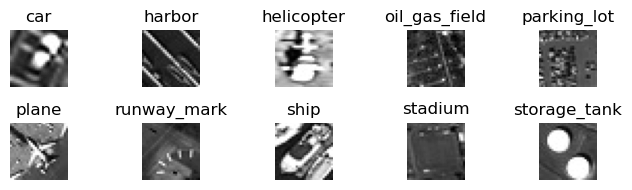

In [12]:
# Plotting the dataset images
Y = np.unique(y_train)
labels = pd.read_csv('./labels.csv')
# Getting the labels for each class
labels = [labels.loc[np.where(labels['label']==n), 'class'].iloc[0] for n in range(10)]

# Getting one image from each class
imgs = np.array([x_train.loc[np.where(y_train == n)[0][0], :] for n in Y])
plt.figure(figsize=(7, 2))
for i in range(len(Y)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i, :].reshape(28, 28), cmap='gray')
    # Set the title as the corresponding label
    plt.title(labels[i])
    # Remove axis ticks
    plt.axis('off')
# Adjust layout
plt.tight_layout()
plt.show()

# Training the MLP on the whole dataset

In [ ]:
# Variables to track the time and memory used by the model
s = time.time()
memBS = process.memory_info().rss

# Hyper Parameters to tune
param_grid = {
    'hidden_layer_sizes': [(256,128,128,128,64,64,64),
                           (256,256,128,128,128,64,64,64),
                           (256,256,256,128,128,128,64,64,64),
                           (256,256,256,128,128,128,64,64,64,32)],
    'activation': ['logistic', 'tanh', 'relu'],
    'max_iter': [100,150,200,250,300]
}

# Hyper-Parameter tunning using GridSearchCV
mlp = MLPClassifier(random_state = 42, early_stopping=False)
mlp_wd = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
mlp_wd.fit(x_train, y_train_onehot)

# Variables to track the time and momory used by the model
e = time.time()
memAF = process.memory_info().rss

In [9]:
# Printing time, memory taken by the model and accuracy on the test data
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
print(f"Accuracy on testing dataset: {mlp_wd.score(x_test, y_test_onehot)*100:.2f}%")
mlp_wd.best_params_

Time taken in training: 7618.94 sec
Memory taken in training: 20612.0 MB
Accuracy on testing dataset: 61.41%


{'activation': 'relu',
 'hidden_layer_sizes': (256, 256, 256, 128, 128, 128, 64, 64, 64),
 'max_iter': 150}

In [10]:
# Predicting on the test data
y_pred = mlp_wd.predict(x_test)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test_onehot, y_pred)
results_df = pd.DataFrame({'Precision': precision,
                           'Recall': recall,
                           'F1 Score': f1_score,
                           'Support': support},
                          index=range(len(precision)))

print("Metrics for each class:")
print(results_df)

Metrics for each class:
   Precision    Recall  F1 Score  Support
0   0.785047  0.750000  0.767123      112
1   0.658537  0.486486  0.559585      111
2   0.851351  0.768293  0.807692       82
3   0.662921  0.536364  0.592965      110
4   0.583333  0.250000  0.350000      112
5   0.892473  0.747748  0.813725      111
6   0.460526  0.700000  0.555556      100
7   0.882353  0.675676  0.765306      111
8   0.540146  0.704762  0.611570      105
9   0.537190  0.585586  0.560345      111


# Taking random sample of 300 example

In [11]:
# Taking 300 examples for training
_, x_train_300, _, y_train_300 = train_test_split(x_train, y_train, test_size=300, stratify=y_train, random_state=0)
x_train_300.shape, y_train_300.shape

((300, 784), (300,))

In [12]:
# Changing into onehot vector
y_train_300_onehot = np.eye(len(classes))[y_train_300]
y_train_300_onehot.shape

(300, 10)

In [ ]:
# Variables to track the time and memory used by the model
s = time.time()
memBS = process.memory_info().rss

# Hyper Parameters to tune
param_grid = {
    'hidden_layer_sizes': [(128,128,128),
                           (128,128,128,64),
                           (256,128,128,128),
                           (256,256,128,128,64,64),
                           (256,256,128,128,64,64,64)],
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100,150,200,250,300]
}

# Hyper-Parameter tunning using GridSearchCV
mlp = MLPClassifier(random_state = 42, early_stopping=False)
mlp_grid_300 = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
mlp_grid_300.fit(x_train_300.values, y_train_300_onehot)

# Variables to track the time and memory used by the model
e = time.time()
memAF = process.memory_info().rss

In [14]:
# Printing time, memory taken by the model and accuracy on the test data
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
print(f"Accuracy on testing dataset: {mlp_grid_20.score(x_test.values, y_test_onehot)*100:.2f}%")
mlp_grid_20.best_params_

Time taken in training: 822.22 sec
Memory taken in training: 456.0 MB
Accuracy on testing dataset: 25.63%


{'activation': 'relu',
 'hidden_layer_sizes': (256, 256, 128, 128, 64, 64),
 'learning_rate': 'constant',
 'max_iter': 250}

In [15]:
# Predicting on the test data
y_pred = mlp_grid_20.predict(x_test)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test_onehot, y_pred)
results_df = pd.DataFrame({'Precision': precision,
                           'Recall': recall,
                           'F1 Score': f1_score,
                           'Support': support},
                          index=range(len(precision)))

print("Metrics for each class:")
print(results_df)

Metrics for each class:
   Precision    Recall  F1 Score  Support
0   0.623529  0.473214  0.538071      112
1   0.375000  0.297297  0.331658      111
2   0.622951  0.463415  0.531469       82
3   0.456522  0.190909  0.269231      110
4   0.113636  0.044643  0.064103      112
5   0.470270  0.783784  0.587838      111
6   0.000000  0.000000  0.000000      100
7   0.489796  0.216216  0.300000      111
8   0.000000  0.000000  0.000000      105
9   0.452381  0.342342  0.389744      111


# Clustering the images into 300 clusters

In [7]:
# Clustering the x_train images 
n_clusters = 300
kmean = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
distances = kmean.fit_transform(x_train.values)

# distance from images to their centroid and their labels
distances.shape, kmean.labels_.shape

((8519, 300), (8519,))

In [8]:
# Finding the nearest image to each centroid
x_train_clust = []
y_train_clust = []
for n in range(n_clusters):
    images_dist = []
    # Getting the indices of images for centroid n
    image_inds = np.where(kmean.labels_ == n)[0]
    for i in image_inds:
        image = x_train.loc[i, :]
        label = y_train.loc[i]
        dist = distances[i, n]
        images_dist.append((image, dist, label))
    
    # Sorting the images_dist list respect to 'dist'
    images_dist.sort(key=lambda x: x[1])
    #  After sorting the first image is nearest to centroid
    # Therefore, we'll take its label
    y_train_clust.append(images_dist[0][2])
    
    # Storing images into x_train_clust
    images = [img.values for img, _, _ in images_dist]
    x_train_clust.append(np.array(images))
    
len(x_train_clust), len(y_train_clust)

(300, 300)

# Take single image which is near to the centroid from each cluster

In [18]:
# Taking image which is nearest to the centroid and its label as training example for each cluster
x_train_clust_1 = np.array([x_train_clust[i][0, :] for i in range(n_clusters)])
y_train_clust_1 = np.array(y_train_clust)

# Changing into onehot vector
y_train_clust_1_onehot = np.eye(len(classes))[y_train_clust_1]
x_train_clust_1.shape, y_train_clust_1_onehot.shape

((300, 784), (300, 10))

In [ ]:
# Variables to track the time and momory used by the model
s = time.time()
memBS = process.memory_info().rss

# Hyper Parameters to tune
param_grid = {
    'hidden_layer_sizes': [(256,128,128,64,16),
                           (256,128,128,64,64),
                           (256,256,128,128,64,64),
                           (256,256,128,128,64,64,64),
                           (256,256,256,128,128,64,64,64)],
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100,150,200,250,300]
}

# Hyper-Parameter tunning using GridSearchCV
mlp = MLPClassifier(random_state = 42, early_stopping=False)
mlp_clust_1 = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
mlp_clust_1.fit(x_train_clust_1, y_train_clust_1_onehot)

# Variables to track the time and momory used by the model
e = time.time()
memAF = process.memory_info().rss

In [20]:
# Printing time, memory taken by the model and accuracy on the test data
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
print(f"Accuracy on testing dataset: {mlp_clust_1.score(x_test.values, y_test_onehot)*100:.2f}%")
mlp_clust_1.best_params_

Time taken in training: 1230.15 sec
Memory taken in training: 17392.0 MB
Accuracy on testing dataset: 32.39%


{'activation': 'tanh',
 'hidden_layer_sizes': (256, 128, 128, 64, 64),
 'learning_rate': 'constant',
 'max_iter': 150}

In [21]:
# Predicting on the test data
y_pred = mlp_clust_1.predict(x_test)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test_onehot, y_pred)
results_df = pd.DataFrame({'Precision': precision,
                           'Recall': recall,
                           'F1 Score': f1_score,
                           'Support': support},
                          index=range(len(precision)))

print("Metrics for each class:")
print(results_df)

Metrics for each class:
   Precision    Recall  F1 Score  Support
0   0.638554  0.473214  0.543590      112
1   0.000000  0.000000  0.000000      111
2   0.787879  0.634146  0.702703       82
3   0.894737  0.154545  0.263566      110
4   0.000000  0.000000  0.000000      112
5   0.826667  0.558559  0.666667      111
6   0.071429  0.020000  0.031250      100
7   0.697917  0.603604  0.647343      111
8   0.179916  0.409524  0.250000      105
9   0.485149  0.441441  0.462264      111


# Propagate the above situation to the entire cluster for each respective cluster

In [14]:
# Taking whole dataset as training data
x_train_clust_100 = np.vstack(x_train_clust)
# Giving all images label which nearest image to the centroid has for each cluster
y_train_clust_100 = np.hstack([np.array([y_train_clust[i]]*x_train_clust[i].shape[0], dtype=int) for i in range(n_clusters)])

# Changing into onehot vector
y_train_clust_100_onehot = np.eye(len(classes))[y_train_clust_100]
x_train_clust_100.shape, y_train_clust_100_onehot.shape

((8519, 784), (8519, 10))

In [32]:
# Variables to track the time and memory used by the model
s = time.time()
memBS = process.memory_info().rss

# Hyper Parameters to tune
param_grid = {
    'hidden_layer_sizes': [(256,256,128,128,64,64),
                           (256,256,128,128,64,64,64),
                           (256,256,256,128,128,64,64,64),
                           (256,256,256,128,128,128,64,64,64),
                           (256,256,256,128,128,128,64,64,64,32)
                           ],
    'activation': ['logistic', 'tanh', 'relu'],
    'max_iter': [10,15,20,50]
}

# Hyper-Parameter tunning using GridSearchCV
mlp = MLPClassifier(random_state = 0, early_stopping=False, shuffle=True)
mlp_clust_100 = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
mlp_clust_100.fit(x_train_clust_100, y_train_clust_100_onehot)

# Variables to track the time and momory used by the model
e = time.time()
memAF = process.memory_info().rss

In [13]:
# Printing time, memory taken by the model and accuracy on the test data
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
print(f"Accuracy on testing dataset: {mlp_clust_100.score(x_test.values, y_test_onehot)*100:.2f}%")
mlp_clust_100.best_params_

Time taken in training: 7385.57 sec
Memory taken in training: 20475.67 MB
Accuracy on testing dataset: 33.43%
{'activation': 'relu', 'hidden_layer_sizes': (256, 256, 128, 128, 64, 64, 64), 'max_iter': 120}


In [34]:
# Predicting on the test data
y_pred = mlp_clust_100.predict(x_test)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test_onehot, y_pred)
results_df = pd.DataFrame({'Precision': precision,
                           'Recall': recall,
                           'F1 Score': f1_score,
                           'Support': support},
                          index=range(len(precision)))

print("Metrics for each class:")
print(results_df)

Metrics for each class:
   Precision    Recall  F1 Score  Support
0   0.792683  0.580357  0.670103      112
1   0.000000  0.000000  0.000000      111
2   0.964286  0.658537  0.782609       82
3   0.857143  0.163636  0.274809      110
4   0.070423  0.044643  0.054645      112
5   1.000000  0.522523  0.686391      111
6   0.144578  0.120000  0.131148      100
7   0.947368  0.162162  0.276923      111
8   0.187243  0.866667  0.307953      105
9   0.589041  0.387387  0.467391      111


# Propagate the clustering to 20% images near to centroid

In [9]:
# Taking 20% of images which are near to the centroids
clust_prc = 0.20
x_train_clust_20 = np.vstack([clust[:int(clust.shape[0]*clust_prc), :] for clust in x_train_clust])
y_train_clust_20 = np.hstack([np.array([y_train_clust[i]]*int(len(x_train_clust[i])*clust_prc), dtype=int) for i in range(len(x_train_clust))])

# Changing into onehot vector
y_train_clust_20_onehot = np.eye(len(classes))[y_train_clust_20]
x_train_clust_20.shape, y_train_clust_20_onehot.shape

((1591, 784), (1591, 10))

In [39]:
# Variables to track the time and momory used by the model
s = time.time()
memBS = process.memory_info().rss

# Hyper Parameters to tune
param_grid = {
    'hidden_layer_sizes': [(256,256,128,128,64,64),
                           (256,256,128,128,64,64,64),
                           (256,256,256,128,128,64,64),
                           (256,256,256,128,128,128,64,64),
                           (256,256,128,128,64,64,64,32),
                           (256,256,128,128,64,64,64,32,32)],
    'activation': ['logistic', 'tanh', 'relu'],
    'max_iter': [100,120,140,160,180]
}

# Hyper-Parameter tunning using GridSearchCV
mlp = MLPClassifier(random_state = 42, early_stopping=False)
mlp_clust_20 = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
mlp_clust_20.fit(x_train_clust_20, y_train_clust_20_onehot)

# Variables to track the time and momory used by the model
e = time.time()
memAF = process.memory_info().rss

In [42]:
# Printing time, memory taken by the model and accuracy on the test data
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
print(f"Accuracy on testing dataset: {mlp_clust_20.score(x_test.values, y_test_onehot)*100:.2f}%")
mlp_clust_20.best_params_

Time taken in training: 1668.98 sec
Memory taken in training: 11972.0 MB
Accuracy on testing dataset: 34.08%


{'hidden_layer_sizes': (256, 256, 256, 128, 128, 64, 64), 'max_iter': 120}

In [38]:
# Predicting on the test data
y_pred = mlp_clust_20.predict(x_test)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test_onehot, y_pred)
results_df = pd.DataFrame({'Precision': precision,
                           'Recall': recall,
                           'F1 Score': f1_score,
                           'Support': support},
                          index=range(len(precision)))

print("Metrics for each class:")
print(results_df)

Metrics for each class:
   Precision    Recall  F1 Score  Support
0   0.466258  0.678571  0.552727      112
1   0.461538  0.054054  0.096774      111
2   0.958333  0.560976  0.707692       82
3   0.863636  0.172727  0.287879      110
4   0.076923  0.008929  0.016000      112
5   0.964912  0.495495  0.654762      111
6   0.156977  0.270000  0.198529      100
7   0.941176  0.144144  0.250000      111
8   0.173448  0.771429  0.283217      105
9   0.795455  0.315315  0.451613      111
